# Neural Algorithmic Reasoning Project
This is a prototype. Using this to understand Neural Algorithmic Reasoning by imitating Belleman Ford


In [107]:
import torch
import networkx as nx
import matplotlib.pyplot as plt

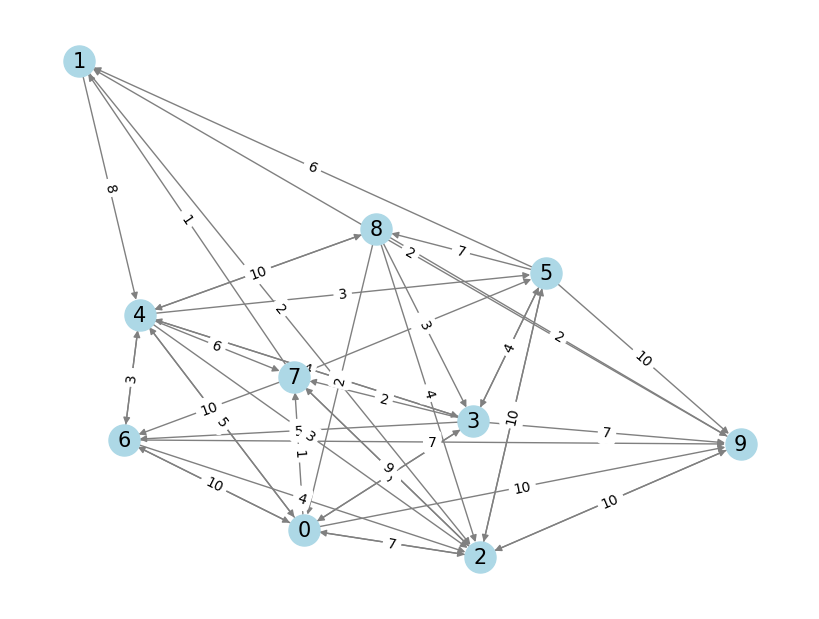

DiGraph with 10 nodes and 45 edges


In [108]:
import random


def gen_graph():
    n = 10  # Number of nodes
    p = 0.5  # Probability of edge creation
    seed = None 
    directed = True

    G = nx.fast_gnp_random_graph(n, p, seed, directed)

    # Create random edge weights
    for (u, v) in G.edges():
        G.edges[u,v]['weight'] = random.randint(1,10)

    return G

G = gen_graph()
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=15)

edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.show()
print(G)
# This image looks bad but it shows that all edges have weights. 

### Dataset

The dataset must have contain not just the input and output node values, it must also contain intermediate steps because we will backpropogate in between steps in order to train the model to align with the algorithm at all steps. 

Therefore, there the dataset will contain 3 tensors.

We will be using an extension of Pytorch Geometric Datasets. Here is a quote from the ReadMe that says what is contained inside a PyG dataset:
---
data.x: Node feature matrix with shape [num_nodes, num_node_features]

data.edge_index: Graph connectivity in COO format with shape [2, num_edges] and type torch.long

data.edge_attr: Edge feature matrix with shape [num_edges, num_edge_features]

data.y: Target to train against (may have arbitrary shape), e.g., node-level targets of shape [num_nodes, *] or graph-level targets of shape [1, *]

data.pos: Node position matrix with shape [num_nodes, num_dimensions]

---
<!-- 
We will not be needing data.pos, but we will need to find a way to add intermediate labels in order to train the whole algorithm trajectory. This will be done by extending the data object with a `data.hints field`. This will be a tensor of dimension `[num_nodes, label, num_time_steps]`. For graph algorithms, this will be the case, but for other algorithms the hints and other data parameters must be adjusted. 

But first, we must run the Belleman Ford Algorithm to generate a synthetic dataset. It should take the graph as an input, and return the hints for each time step and the final output. -->

The data will be represented as a single matrix of dimensions num nodes * num time steps,
the first time step will be the state of the graph after the bellman ford algorithm has been run once. 
The input will be the node edge weights. The outputs will be the last time step located in the same matrix. 

In [109]:
# Run the Belleman Ford Algorithm, return a numpy array containing the output of the algorithm at each time step for each node.

import numpy as np
# Note: In this case, we will assume node 0 is the source node.
def belleman_ford(graph):
    distance = {node: float('inf') for node in G.nodes}
    distance[0] = 0
    
    print(G.edges(data=True))
    
    states = []
    
    for _ in range(len(G.nodes) - 1):
        for u, v, data in G.edges(data=True):
            weight = data['weight']
            if distance[u] + weight < distance[v]:
                distance[v] = distance[u] + weight

          #  print(distance)
        array = np.array(list(distance.values()))
        states.append(array)
        
    
    return np.stack(states, axis=1)

       
     

print(belleman_ford(G))


[(0, 2, {'weight': 7}), (0, 3, {'weight': 3}), (0, 4, {'weight': 7}), (0, 6, {'weight': 10}), (0, 7, {'weight': 1}), (0, 9, {'weight': 10}), (1, 2, {'weight': 2}), (1, 4, {'weight': 8}), (2, 5, {'weight': 9}), (2, 7, {'weight': 2}), (2, 9, {'weight': 8}), (2, 0, {'weight': 7}), (3, 4, {'weight': 6}), (3, 5, {'weight': 3}), (3, 6, {'weight': 5}), (3, 7, {'weight': 2}), (3, 9, {'weight': 7}), (3, 0, {'weight': 3}), (4, 5, {'weight': 3}), (4, 6, {'weight': 9}), (4, 7, {'weight': 6}), (4, 8, {'weight': 2}), (4, 0, {'weight': 5}), (4, 2, {'weight': 3}), (4, 3, {'weight': 4}), (5, 8, {'weight': 7}), (5, 9, {'weight': 10}), (5, 1, {'weight': 6}), (5, 2, {'weight': 10}), (5, 3, {'weight': 4}), (6, 9, {'weight': 7}), (6, 0, {'weight': 10}), (6, 2, {'weight': 4}), (6, 4, {'weight': 3}), (7, 1, {'weight': 1}), (7, 2, {'weight': 9}), (7, 5, {'weight': 7}), (7, 6, {'weight': 10}), (8, 9, {'weight': 2}), (8, 0, {'weight': 2}), (8, 2, {'weight': 4}), (8, 3, {'weight': 3}), (8, 4, {'weight': 10}), (9,

Now that we have a graph, and its states at each time step, we will make the dataset.

In [111]:

from torch_geometric.data import InMemoryDataset, Data

from networkx import to_edgelist
# Function to generate a single graph, or sample.

def generate_data():
    # The first thing it will do is generate a networkx graph.
    graph = gen_graph()
    
    # Then Apply the Bellman Ford algo
    b_ford = belleman_ford(graph)
    
    edges = to_edgelist(graph)
    
    src = []
    dst = []
    edge_weights = []
    for u, v, w in graph.edges(data=True):
        src.append(u)
        dst.append(v)
        edge_weights.append(w['weight'])
    
    src = torch.tensor(src)
    dst = torch.tensor(dst)
    edge_index = torch.stack([src, dst], dim=0)
    
   
    edge_weights = torch.tensor(edge_weights)
    
    
    # X is empty in case we want to fill it in later
    
    
    data = Data(
        edge_index=edge_index,
        edge_attr=edge_weights,
        y=b_ford,
        x=torch.zeros(len(graph.nodes))
    )
    return data

print(generate_data())




[(0, 2, {'weight': 7}), (0, 3, {'weight': 3}), (0, 4, {'weight': 7}), (0, 6, {'weight': 10}), (0, 7, {'weight': 1}), (0, 9, {'weight': 10}), (1, 2, {'weight': 2}), (1, 4, {'weight': 8}), (2, 5, {'weight': 9}), (2, 7, {'weight': 2}), (2, 9, {'weight': 8}), (2, 0, {'weight': 7}), (3, 4, {'weight': 6}), (3, 5, {'weight': 3}), (3, 6, {'weight': 5}), (3, 7, {'weight': 2}), (3, 9, {'weight': 7}), (3, 0, {'weight': 3}), (4, 5, {'weight': 3}), (4, 6, {'weight': 9}), (4, 7, {'weight': 6}), (4, 8, {'weight': 2}), (4, 0, {'weight': 5}), (4, 2, {'weight': 3}), (4, 3, {'weight': 4}), (5, 8, {'weight': 7}), (5, 9, {'weight': 10}), (5, 1, {'weight': 6}), (5, 2, {'weight': 10}), (5, 3, {'weight': 4}), (6, 9, {'weight': 7}), (6, 0, {'weight': 10}), (6, 2, {'weight': 4}), (6, 4, {'weight': 3}), (7, 1, {'weight': 1}), (7, 2, {'weight': 9}), (7, 5, {'weight': 7}), (7, 6, {'weight': 10}), (8, 9, {'weight': 2}), (8, 0, {'weight': 2}), (8, 2, {'weight': 4}), (8, 3, {'weight': 3}), (8, 4, {'weight': 10}), (9,